# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

In [71]:
# To help you get started...
from IPython.display import display
from os.path import join, isfile
from os import listdir

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from scipy.fft import fft
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
import re
import numpy as np
%matplotlib inline 



I stored all the data in a folder called exampleco_data. This first cell loads machine_0's data to check and see the data

The second cell iterates through all files that fit the 'machine_XX.csv' file name format and joins them all together

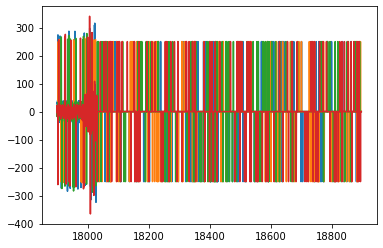

In [72]:
path = '../exampleco_data'
df_machine_0 = pd.read_csv(join(path, 'machine_0.csv'),index_col=0)
dates = date2num(df_machine_0.index)

plt.plot(dates, df_machine_0)
plt.show()

In [73]:
df_machine_data = pd.DataFrame()

files = [f for f in listdir(path) if isfile(join(path, f))]

for file in files:
    if re.match(r'machine_[0-9]+.csv', file):
        df_ind_machine_data = pd.read_csv(join(path, file),index_col=0)
        df_ind_machine_data['source'] = file
        df_machine_data = df_machine_data.append(df_ind_machine_data)
        print(file + ' added to dataframe')

df_ind_machine_data = pd.read_csv(join(path, file),index_col=0)
orig_columns = df_ind_machine_data.columns.tolist()
        

machine_0.csv added to dataframe
machine_1.csv added to dataframe
machine_10.csv added to dataframe
machine_11.csv added to dataframe
machine_12.csv added to dataframe
machine_13.csv added to dataframe
machine_14.csv added to dataframe
machine_15.csv added to dataframe
machine_16.csv added to dataframe
machine_17.csv added to dataframe
machine_18.csv added to dataframe
machine_19.csv added to dataframe
machine_2.csv added to dataframe
machine_3.csv added to dataframe
machine_4.csv added to dataframe
machine_5.csv added to dataframe
machine_6.csv added to dataframe
machine_7.csv added to dataframe
machine_8.csv added to dataframe
machine_9.csv added to dataframe


First we want to normalize the 4 datasets with 0 mean (no bias) and a standard deviation of 1 so that we dont run into numerical issues later on and/or so that the different variables are of the same magnitude if we do some work later. We also want to save these means and standard deviations in case we need to re-normalize individual machines.

In [74]:
def normalize(df_col):
    return ((df_col - df_col.mean())/df_col.std(), df_col.mean(), df_col.std())

def normalize_dataset(df, cols):
    df_mean_std = pd.DataFrame(columns = ['mean', 'std'])
    for col in cols:
        (df[col + '_normalized'], mean, std) = normalize(df[col])
        df_mean_std.loc[col, 'mean'] = mean
        df_mean_std.loc[col, 'std'] = std
    return (df, df_mean_std)
    
normalized_columns = [col + '_normalized' for col in orig_columns]
(df_machine_data, df_col_stats) = normalize_dataset(df_machine_data, orig_columns)

We see that the distribution of the 4 variables show that they lie in pretty distinct and easily recognizable cluster. I suspect these are the points from the noise and/or communication errors. I also calculated (not captured in this notebook) that the occurence of noise seems to be independent amongst the 4 varaibles (i.e. if one sensor experiences noise/communication error, this does NOT affect the likelihood that the others will experience noise). 

All 3 of the variables seem to experience noise 4 sigma away from the majority of their signals. I decided to filter out any data points 3 that are 3 standard deviations/sigmas away from the mean. I replaced them with linearly interpolated points instead.

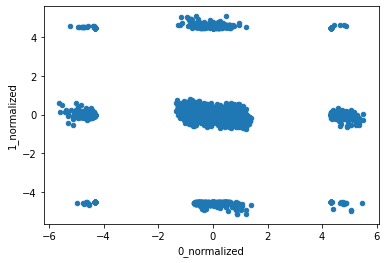

In [75]:
axes = df_machine_data.plot.scatter('0_normalized', '1_normalized')

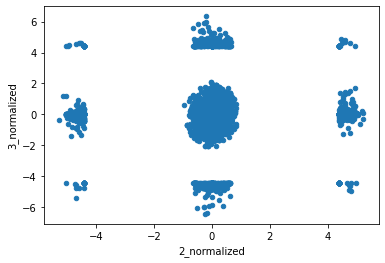

In [76]:
axes = df_machine_data.plot.scatter('2_normalized', '3_normalized')

In [77]:
SIGMA_THRESHOLD = 3

def clean_data_col(df_col):
    df_cleaned_col = df_col.apply(lambda x: x if abs(x)<SIGMA_THRESHOLD else np.nan)
    df_cleaned_col.interpolate(axis='index', inplace = True)
    return df_cleaned_col

def clean_dataset(df, cols):
    for col in cols:
        df[col + '_cleaned'] = clean_data_col(df[col + '_normalized'])
    return df
    
cleaned_columns = [col + '_cleaned' for col in orig_columns]
df_machine_data = clean_dataset(df_machine_data, orig_columns)

Applying this methodology to one turbine, we see 3 distinct areas: normal sinusoids presumably for normal operation, an eratic exponentially growing sinuoid for faulty operation and a series of near-zero values likely for failed operations

In [78]:
df_machine_2 = df_machine_data.loc[df_machine_data['source'] == 'machine_2.csv',:]

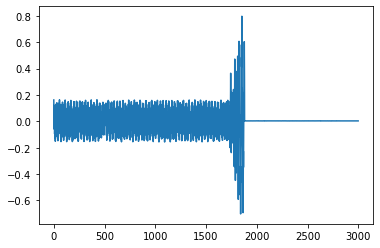

In [79]:
plt.plot(range(len(df_machine_2['1_cleaned'])), df_machine_2['1_cleaned'])
plt.show()

Zooming into normal operation, I apply a Fast Fourier Transform to see it in frequency domain

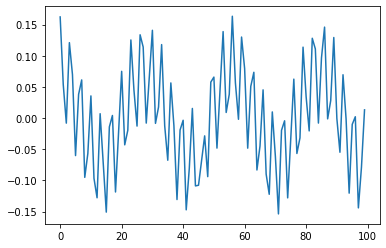

In [80]:
start = 0
end = 100

plt.plot(range(start, end), df_machine_2['1_cleaned'][start:end])
plt.show()

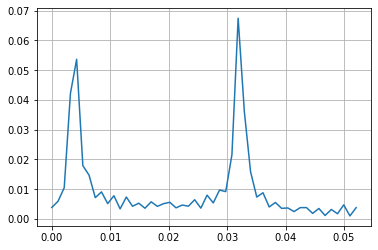

In [81]:
T = 9.6 #s
N = end-start

yf = fft(df_machine_2['1_cleaned'][start:end].tolist())
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

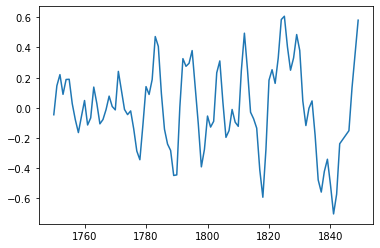

In [82]:
start = 1750
end = 1850

plt.plot(range(start, end), df_machine_2['1_cleaned'][start:end])
plt.show()

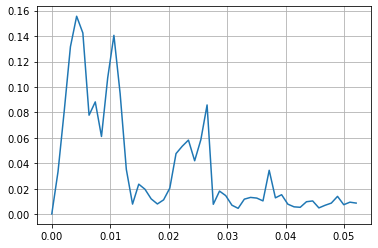

In [83]:
T = 9.6 #s
N = end-start

yf = fft(df_machine_2['1_cleaned'][start:end].tolist())
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [84]:
MOVING_AVERAGE = 5

def smooth_data_col(df_col):
    df_smoothed_col = df_col.rolling(MOVING_AVERAGE, win_type = 'triang').sum()
    return df_smoothed_col

def smooth_dataset(df, cols):
    for col in cols:
        df[col + '_smoothed'] = smooth_data_col(df[col + '_cleaned'])
    return df
    
smoothed_columns = [col + '_smoothed' for col in orig_columns]
df_machine_data = smooth_dataset(df_machine_data, orig_columns)

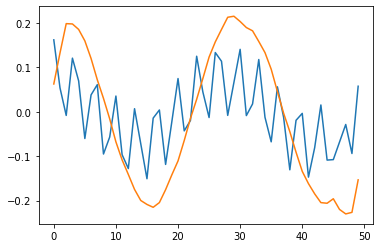

In [85]:
df_machine_2 = df_machine_data.loc[df_machine_data['source'] == 'machine_2.csv',:]
start = 0
end = 50

plt.plot(range(start, end), df_machine_2[['1_cleaned','1_smoothed']][start:end])
plt.show()

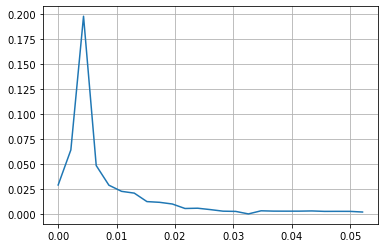

In [86]:
T = 9.6 #s
N = end-start

yf = fft(df_machine_2['1_smoothed'][start:end].tolist())
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

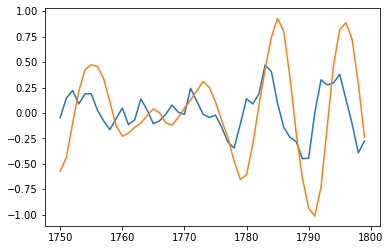

In [87]:
df_machine_2 = df_machine_data.loc[df_machine_data['source'] == 'machine_2.csv',:]
start = 1750
end = 1800

plt.plot(range(start, end), df_machine_2[['1_cleaned','1_smoothed']][start:end])
plt.show()

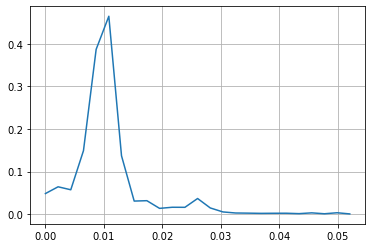

In [88]:
T = 9.6 #s
N = end-start

yf = fft(df_machine_2['1_smoothed'][start:end].tolist())
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [89]:
FFT_HORIZON = 30
DENOM_BIAS = 0.002

def calculate_THD(yf):
    v_max = max(yf)
    v_non_fund = yf.copy()
    v_non_fund.remove(v_max)
    num = np.linalg.norm(v_non_fund)
    denom = np.linalg.norm(yf)
    return num/(denom+DENOM_BIAS)

def rolling_fft_to_thd(df):
    lst = df.tolist()
    yf = fft(lst)
    yf = 2.0/FFT_HORIZON * np.abs(yf[0:FFT_HORIZON//2])
    return calculate_THD(np.abs(yf[0:FFT_HORIZON//2]).tolist())

def fft_v_max(df):
    lst = df.tolist()
    yf = fft(lst)
    yf = 2.0/FFT_HORIZON * np.abs(yf[0:FFT_HORIZON//2])
    v_max = max(yf)
    return v_max

def distortion_col(df_col):
    df_distort_col = df_col.rolling(FFT_HORIZON).apply(rolling_fft_to_thd)
    df_distort_col.fillna(method = 'backfill', inplace = True)
    return df_distort_col

def vmax_col(df_col):
    df_vmax_col = df_col.rolling(FFT_HORIZON).apply(fft_v_max)
    df_vmax_col.fillna(method = 'backfill', inplace = True)
    return df_vmax_col

machine_list = df_machine_data['source'].unique().tolist()

for machine in machine_list:
    for col in orig_columns:
        machine_cols = df_machine_data['source'] == machine
        df_machine_data.loc[machine_cols, col + '_THD'] = distortion_col(df_machine_data.loc[machine_cols, col + '_smoothed'])
        df_machine_data.loc[machine_cols, col + '_FFT_vmax'] = vmax_col(df_machine_data.loc[machine_cols, col + '_smoothed'])

In [90]:
THD_columns = [col + '_THD' for col in orig_columns]
FFT_vmax_columns = [col + '_FFT_vmax' for col in orig_columns]

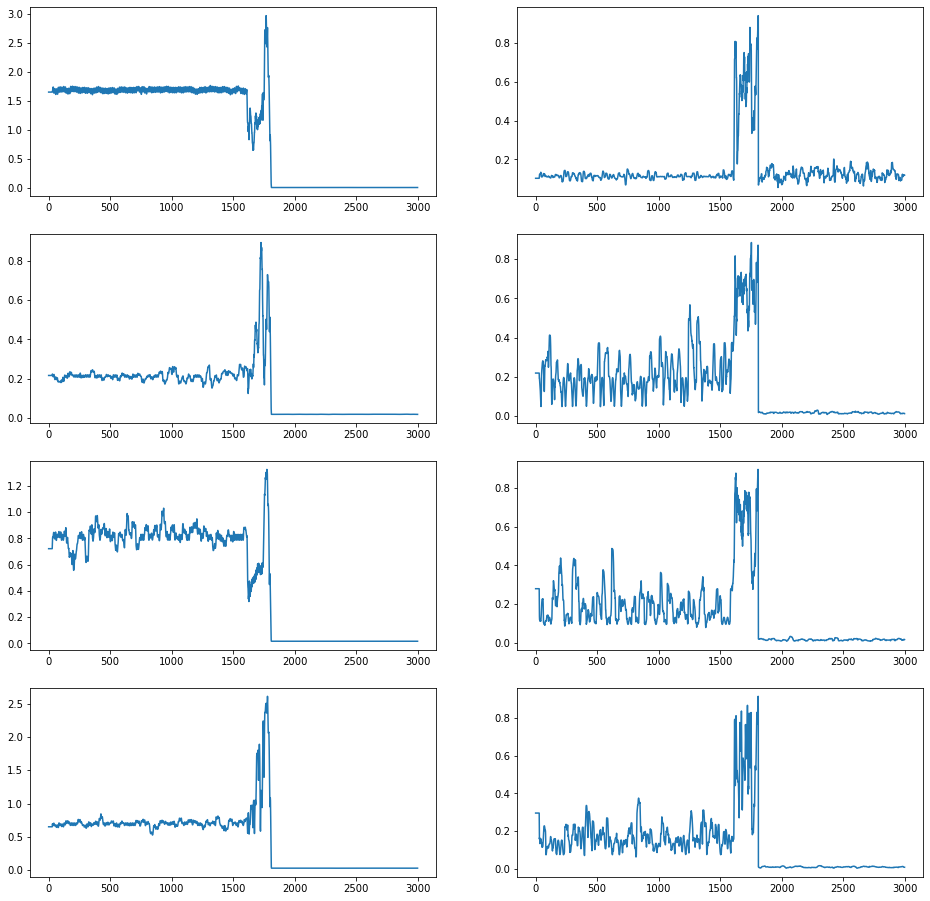

In [91]:
machine = 'machine_15.csv'
machine_cols = df_machine_data['source'] == machine
df_machine = df_machine_data.loc[machine_cols, :]

start = 0
end = 3000

plt.figure(figsize = (16,16))
plt.subplot(421)
plt.plot(range(start, end), df_machine['0_FFT_vmax'][start:end])
plt.subplot(423)
plt.plot(range(start, end), df_machine['1_FFT_vmax'][start:end])
plt.subplot(425)
plt.plot(range(start, end), df_machine['2_FFT_vmax'][start:end])
plt.subplot(427)
plt.plot(range(start, end), df_machine['3_FFT_vmax'][start:end])

plt.subplot(422)
plt.plot(range(start, end), df_machine['0_THD'][start:end])
plt.subplot(424)
plt.plot(range(start, end), df_machine['1_THD'][start:end])
plt.subplot(426)
plt.plot(range(start, end), df_machine['2_THD'][start:end])
plt.subplot(428)
plt.plot(range(start, end), df_machine['3_THD'][start:end])

In [92]:
pca = PCA(n_components=8)
pca.fit(df_machine_data.loc[:,THD_columns+FFT_vmax_columns])
transformed_data = pca.transform(df_machine_data.loc[:,THD_columns+FFT_vmax_columns])
df_machine_data['pca_dim1'] = transformed_data[:,0]
df_machine_data['pca_dim2'] = transformed_data[:,1]

<AxesSubplot:xlabel='pca_dim1', ylabel='pca_dim2'>

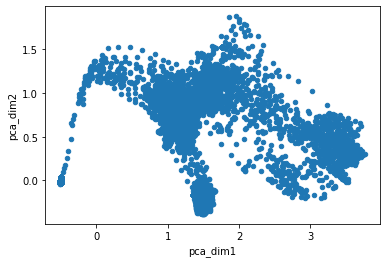

In [93]:
df_machine_data.plot.scatter('pca_dim1', 'pca_dim2')

In [94]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_machine_data[THD_columns+FFT_vmax_columns].to_numpy())

<AxesSubplot:xlabel='pca_dim1', ylabel='pca_dim2'>

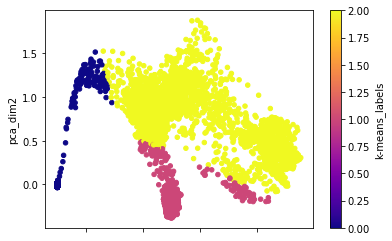

In [95]:
df_machine_data['k-means_labels'] = kmeans.labels_
df_machine_data.plot.scatter('pca_dim1', 'pca_dim2', c = 'k-means_labels', colormap='plasma')

C:\Users\Wintermute-III\anaconda3\envs\dschallenge\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


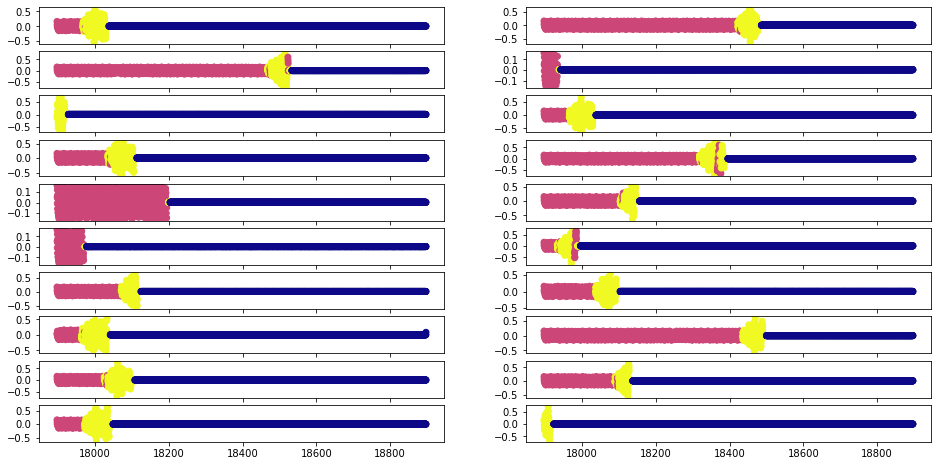

In [127]:
start = 0
end = 3000
plt.figure(figsize = (16,8))
for i in range(20):
    machine = 'machine_' + str(i) + '.csv'
    machine_cols = df_machine_data['source'] == machine
    df_machine = df_machine_data.loc[machine_cols, :]
    df_machine['time']=date2num(df_machine.index)
    
    plt.subplot2grid((10,2), (i//2,i%2))
    plt.scatter(df_machine['time'], df_machine['1_cleaned'], c = df_machine['k-means_labels'], cmap='plasma')
    
plt.show()